# Bank Customer Churn Prediction

### loading data

In [1]:
import pandas as pd

dataset = pd.read_csv("Bank Customer Churn Prediction.csv")

In [2]:
print("number of datapoints : {}\nnumber of features : {}".format(dataset.shape[0],dataset.shape[1]))

number of datapoints : 10000
number of features : 12


In [3]:
dataset.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### dropping customer_id

In [4]:
dataset = dataset.drop(columns ="customer_id")
dataset.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### checking categorical features

In [5]:
import numpy as np
print(np.unique(dataset.loc[:,"country"].to_numpy()))
print(np.unique(dataset.loc[:,"gender"].to_numpy()))

['France' 'Germany' 'Spain']
['Female' 'Male']


### one hot encoding

In [6]:
dataset = pd.get_dummies(dataset)
dataset.head()

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,country_France,country_Germany,country_Spain,gender_Female,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1,1,0


In [7]:
print("number of datapoints : {}\nnumber of features : {}".format(dataset.shape[0],dataset.shape[1]))

number of datapoints : 10000
number of features : 14


### turning dataframe into suitable array forms

In [8]:
labels = dataset.loc[:,"churn"].to_numpy()
dataset = dataset.drop(columns ="churn")
fetureNames = dataset.columns.to_numpy()
data = dataset.to_numpy()

print(labels)
print(fetureNames)
print(data)

[1 0 1 ... 1 1 0]
['credit_score' 'age' 'tenure' 'balance' 'products_number' 'credit_card'
 'active_member' 'estimated_salary' 'country_France' 'country_Germany'
 'country_Spain' 'gender_Female' 'gender_Male']
[[619.  42.   2. ...   0.   1.   0.]
 [608.  41.   1. ...   1.   1.   0.]
 [502.  42.   8. ...   0.   1.   0.]
 ...
 [709.  36.   7. ...   0.   1.   0.]
 [772.  42.   3. ...   0.   0.   1.]
 [792.  28.   4. ...   0.   1.   0.]]


### checking label counts

[7963 2037]


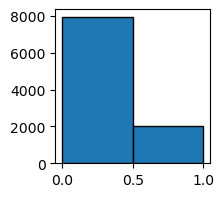

In [9]:
import matplotlib.pyplot as plt

print(np.bincount(labels))
plt.figure(figsize=(2,2))
plt.hist(labels,2,edgecolor = "black")
plt.show()

**data is imbalanced** ( i will manage it later )

### visualizing data (with pca dim reduction)

(10000, 2)


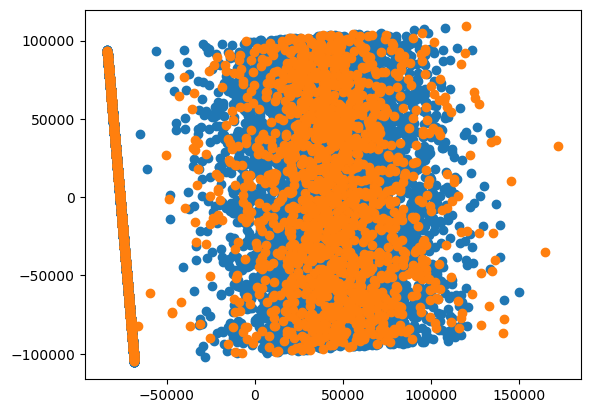

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit_transform(data)
print(pca.shape)
x0,y0,x1,y1=[],[],[],[] # X CLASS 0 / Y CLASS 0 / X CLASS 1 / Y CLASS 1
for i in range(len(labels)):
    if(labels[i]==0):
        x0.append(pca[i,0])
        y0.append(pca[i,1])
    else:
        x1.append(pca[i,0])
        y1.append(pca[i,1])
plt.scatter(x0,y0)
plt.scatter(x1,y1)
plt.show()

we can again see that data is imbalanced , nothing more can be learned from this

### trying a simple model ( logistic regression )

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(data,labels,random_state=0)

logreg = LogisticRegression()
logreg.fit(X_train,Y_train)
logreg_pred = logreg.predict(X_test)
testScore = logreg.score(X_test,Y_test)
trainScore = logreg.score(X_train,Y_train)
print("pure logisticRegression test score : {:.2f}".format(testScore*100))
print("pure logisticRegression train score : {:.2f}".format(trainScore*100))

pure logisticRegression test score : 78.76
pure logisticRegression train score : 79.09


**clearly underfitting (same test and train score)**<br>
i will tune hyperparameters later 

### trying a more complicated model (random forest)

In [12]:
from sklearn.ensemble import RandomForestClassifier

rForest = RandomForestClassifier()
rForest.fit(X_train,Y_train)
rForest_pred = rForest.predict(X_test)
score = rForest.score(X_test,Y_test)
print("pure random forest score : {:.2f}".format(score*100))

pure random forest score : 87.00


### feature selection
it seems that some of the features like country and gender are not useful so i need to check feature importance

In [13]:
from sklearn.feature_selection import SelectFromModel
select = SelectFromModel(RandomForestClassifier(random_state=50),threshold=0.03).fit(X_train,Y_train)
fs_X_train = select.transform(X_train)
support = select.get_support()
print(dict(zip(fetureNames,support)))

{'credit_score': True, 'age': True, 'tenure': True, 'balance': True, 'products_number': True, 'credit_card': False, 'active_member': True, 'estimated_salary': True, 'country_France': False, 'country_Germany': False, 'country_Spain': False, 'gender_Female': False, 'gender_Male': False}


as expected country and gender are not selected so it worth to try the score without them

In [14]:
fs_X_test = select.transform(X_test)
logreg_fs_score = LogisticRegression().fit(fs_X_train,Y_train).score(fs_X_test,Y_test)
rForest_fs_score = RandomForestClassifier().fit(fs_X_train,Y_train).score(fs_X_test,Y_test)

print("logestic regression score with feature selection",logreg_fs_score*100)
print("random forest score with feature selection",rForest_fs_score*100)

logestic regression score with feature selection 78.75999999999999
random forest score with feature selection 85.2


note : random forest has a feauture importance and analyis could be done without select from model , select from model used to check if getting better performance is posiible with that or not

no benefits in applying this selection , it will lower the score and change in computation is not that much

### checking confusion matrix 
data is imbalanced so it seems that we are being optimistic in prediction

In [15]:
from sklearn.metrics import confusion_matrix,f1_score

matrix = confusion_matrix(Y_test,logreg_pred)
print(matrix)
print("\nf1 score of the log reg : {:.2f}".format(f1_score(Y_test,logreg_pred)*100))

[[1940   51]
 [ 480   29]]

f1 score of the log reg : 9.85


too many FP and FN , very poor f1 score

### more analysing about being imbalanced

In [16]:
from sklearn.metrics import classification_report

print("logestic regression\n",classification_report(Y_test,logreg_pred,target_names=["not churn","churn"]))
print("random forest\n",classification_report(Y_test,rForest_pred,target_names=["not churn","churn"]))


logestic regression
               precision    recall  f1-score   support

   not churn       0.80      0.97      0.88      1991
       churn       0.36      0.06      0.10       509

    accuracy                           0.79      2500
   macro avg       0.58      0.52      0.49      2500
weighted avg       0.71      0.79      0.72      2500

random forest
               precision    recall  f1-score   support

   not churn       0.88      0.96      0.92      1991
       churn       0.78      0.51      0.61       509

    accuracy                           0.87      2500
   macro avg       0.83      0.73      0.77      2500
weighted avg       0.86      0.87      0.86      2500



predicting false not churn will have **very high impact** (some one hase been churned and we did not found out !)<br>
predicting false churn has lower impact. ( someone has not churned but we falsly predicted he that he does , it does not have very high business impact , just some adittional researches about customer will be done )<br>
so reducing false negatives is important for us , it means that **recall** is more important for us<br>
<br>
RECALL = TP/(TP+FN)
<br><br>
so i try to increase recall, recall is 6 percent as above report

### precission recall curve

log red closest to mid threshold : -0.002867356919858705
random forest closest to mid threshold : 0.5


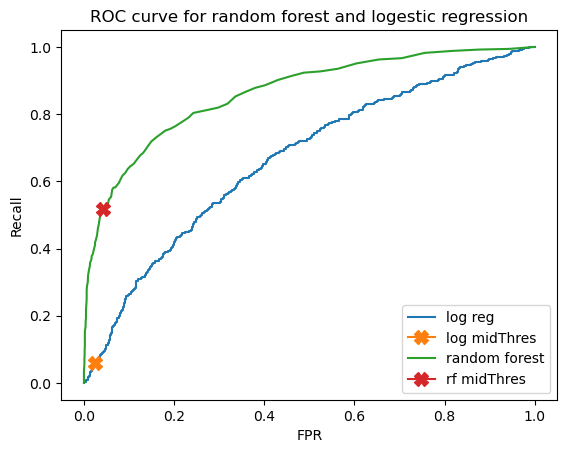

in log reg for mid threshold fpr is 2.56 and recall is 5.89
in random forest for mid threshold fpr is 4.27 and recall is 51.67


In [17]:
from sklearn.metrics import roc_curve

log_decesionFunc = logreg.decision_function(X_test)
forest_predictProba = rForest.predict_proba(X_test)[:,1]

fpr_log, recall_log, threshold_log = roc_curve(Y_test,log_decesionFunc)
fpr_rf, recall_rf, threshold_rf = roc_curve(Y_test,forest_predictProba)

midThres_log = np.argmin(np.abs(threshold_log)) # abs is for ignoring negative values / zero is middle in decision func
midThres_rf = np.argmin(np.abs(threshold_rf-0.5)) # abs is for ignoring negative values / 0.5 is middle in pred proba

print("log red closest to mid threshold :",threshold_log[midThres_log])
print("random forest closest to mid threshold :",threshold_rf[midThres_rf])

plt.plot(fpr_log,recall_log,label = "log reg")
plt.plot(fpr_log[midThres_log],recall_log[midThres_log],marker="X",markersize=10,label = "log midThres")
plt.plot(fpr_rf,recall_rf,label = "random forest")
plt.plot(fpr_rf[midThres_rf],recall_rf[midThres_rf],marker="X",markersize=10,label = "rf midThres")

plt.title("ROC curve for random forest and logestic regression")
plt.xlabel("FPR")
plt.ylabel("Recall")
plt.legend()
plt.show()
print("in log reg for mid threshold fpr is {:.2f} and recall is {:.2f}"
      .format(fpr_log[midThres_log]*100,recall_log[midThres_log]*100))
print("in random forest for mid threshold fpr is {:.2f} and recall is {:.2f}"
      .format(fpr_rf[midThres_rf]*100,recall_rf[midThres_rf]*100))

log reg is acting very bad , rand forest is acting better and is also not very slow like svm so i igonre log reg
<br>maybe with some feature engineering it act better but time complexity does not differ

checking auc too :

In [18]:
from sklearn.metrics import roc_auc_score

print("auc score for log reg :",roc_auc_score(Y_test,log_decesionFunc)*100)
print("auc score for rf :",roc_auc_score(Y_test,forest_predictProba)*100)

auc score for log reg : 66.56683957968028
auc score for rf : 86.2788737925774


from roc curve we understand that with a **lower** threshold we will get a better recall and a balanced FPR<br>
so i extend random forest estimator so it can predict with respect to threshold<br>

### customized random forest

In [19]:
from sklearn.base import BaseEstimator,ClassifierMixin
from sklearn.metrics import accuracy_score

class CRF(BaseEstimator,ClassifierMixin):
    
    def __init__(self,thres=0.5,max_features="sqrt",max_depth=None,n_estimator=100): # adding threshold as a hyper parameter
        self.threshold = thres
        self.max_features = max_features
        self.max_depth = max_depth
        self.n_estimator = n_estimator
        self.subEstimator = RandomForestClassifier(max_depth=max_depth,max_features=max_features,n_estimators=n_estimator)


    def fit(self,X,y):
        return self.subEstimator.fit(X,y)
        
    def predict(self,X): # with respect to pred proba
        predProba = self.subEstimator.predict_proba(X)[:,1]
        pred = predProba >= self.threshold 
        pred = pred.astype(int)
        return pred

    def score(self,X,y):
        return accuracy_score(self.predict(X),y) 
#         return f1_score(y,self.predict(X))

    def get_params(self, deep: bool = True) -> dict:
        params = {"thres":self.threshold,
                  "max_depth":self.max_depth,
                  "max_features":self.max_features,
                  "n_estimator":self.n_estimator}
        return params
    

In [20]:
# testing
crf = CRF(thres = 0.4)
crf.fit(X_train,Y_train)
# results should be near each other
print("score for default random forest :",rForest.score(X_test,Y_test)*100)
print("score for custom random forest with thres 0.4 :",crf.score(X_test,Y_test)*100)
print("f1 score for default random forest :",f1_score(Y_test,rForest_pred)*100)
print("f1 score for custom random forest with thres 0.4 :",f1_score(Y_test,crf.predict(X_test))*100)


score for default random forest : 87.0
score for custom random forest with thres 0.4 : 85.68
f1 score for default random forest : 61.35552913198574
f1 score for custom random forest with thres 0.4 : 63.394683026584865


we can see the increase in f1score

## visualizing the ROC curve again for finding a good threshold range 
less than 0.2 is not very good means that we are accepting low probs to churn
it will decrease score , we will have a trade off between these two later (recall and f1score)

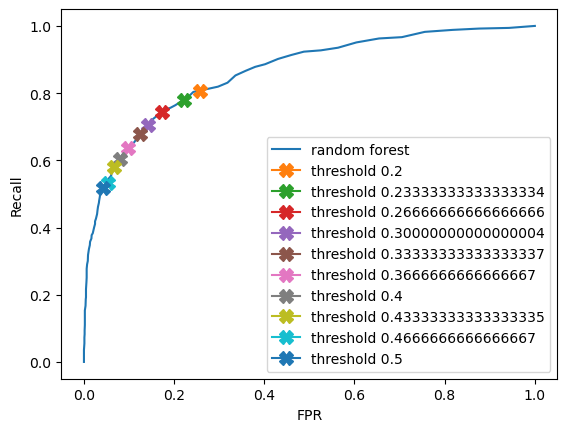

In [21]:
plt.plot(fpr_rf,recall_rf,label = "random forest")
thresRange = np.linspace(0.2,0.5,10)
for threshold in thresRange:
    Thres = np.argmin(np.abs(threshold_rf-threshold))
    plt.plot(fpr_rf[Thres],recall_rf[Thres],marker="X",markersize=10,label = "threshold "+str(threshold))

plt.xlabel("FPR")
plt.ylabel("Recall")
plt.legend()
plt.show()

## finding best threshold

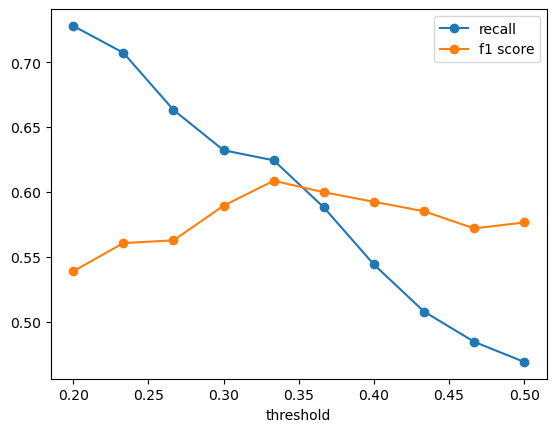

In [22]:
from sklearn.metrics import recall_score

X_train2,X_eval,y_train2,y_eval = train_test_split(X_train,Y_train,random_state=0)

recalls = []
f1scores = []
for thres in thresRange: # 10 models will be trained
    temp_crf = CRF(thres)
    temp_crf.fit(X_train2,y_train2)
    recalls.append(recall_score(y_eval,temp_crf.predict(X_eval)))
    f1scores.append(f1_score(y_eval,temp_crf.predict(X_eval)))

plt.plot(thresRange,recalls,marker="o",label="recall")
plt.plot(thresRange,f1scores,marker="o",label="f1 score")

plt.legend()
plt.xlabel("threshold")
plt.show()

we can see that by increasing threshold recall will be lowered and from from 0.35 f1 score will be lowered from left and right .<br>
we can also see that recall is decreasing from left to right,from 0.3 to the left recall increase very fast and f1score decreases slow from 0.24 to 0.35<br>
so it seems that **0.25** is a perfect threshold , lets try that


In [23]:
crf = CRF(0.25)
crf.fit(X_train,Y_train)
print(classification_report(Y_test,crf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.81      0.87      1991
           1       0.51      0.76      0.61       509

    accuracy                           0.80      2500
   macro avg       0.72      0.79      0.74      2500
weighted avg       0.84      0.80      0.81      2500



result changed as below :<br>
precision : lowered around 25 percent<br>
recall : improved around 25 percent<br>
f1-score : just a very small change !<br>
<br><br>
**so we successfully increased recall without losing f1-score**<br>
now we try to improve overall model (whole f1 score)

### tunning random forest
rf does not need transformation so i just use a simple grid search to find best 

note : large n_stimator is always better , but we know random forest is random and trees that being maid with diffrent params may result in a better performance

In [24]:
def plotGridResult(grid,paramGrid):
    keys = list(paramGrid.keys())
    x=len(paramGrid[keys[0]])
    y=len(paramGrid[keys[1]])
    params = np.array(grid.cv_results_["params"]).reshape(x,y)
    mean_scores = grid.cv_results_["mean_test_score"].reshape(x,y)

    plt.matshow(mean_scores)
    for (i, j), z in np.ndenumerate(mean_scores):
        plt.text(j, i, 's:{:0.3f}\na:{}\nb:{}'.format(z,params[i][j][keys[0]],params[i][j][keys[1]]),
                ha='center', va='center',size=7,
                 bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    plt.colorbar()
    plt.title("s is score\na is {}\nb is {}".format(keys[0],keys[1]))
    plt.show()

train score : 0.9872
test score 0.8024


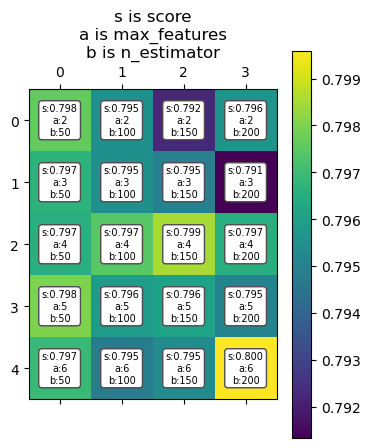

In [25]:
from sklearn.model_selection import GridSearchCV

paramGrid = {"max_features":[2,3,4,5,6],
             "n_estimator":[50,100,150,200]}

grid = GridSearchCV(CRF(thres=0.25),paramGrid,cv=3)
grid.fit(X_train,Y_train)
print("train score :",grid.score(X_train,Y_train))
print("test score",grid.score(X_test,Y_test))
plotGridResult(grid,paramGrid)

we are overfitting , let try max_depth that reduce overfitting and see what will happen

In [26]:
paramGrid = {"max_features":[4,5,6],"max_depth":[4,5,6],
             "n_estimator":[100,150,200]}

grid = GridSearchCV(CRF(thres=0.25),paramGrid,cv=3)
grid.fit(X_train,Y_train)
print("train score :",grid.score(X_train,Y_train))
print("test score",grid.score(X_test,Y_test))
print("best params :",grid.best_params_)


train score : 0.8204
test score 0.8116
best params : {'max_depth': 5, 'max_features': 5, 'n_estimator': 150}


now we are not overfitting<br>
the final result is :

In [27]:
print(classification_report(Y_test,grid.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      0.84      0.88      1991
           1       0.53      0.71      0.61       509

    accuracy                           0.81      2500
   macro avg       0.72      0.77      0.74      2500
weighted avg       0.84      0.81      0.82      2500



In [28]:
print("Confusion matrix :\n",confusion_matrix(Y_test,grid.predict(X_test)))
print("f1score is : {} with recall {}".format(f1_score(Y_test,grid.predict(X_test)),recall_score(Y_test,grid.predict(X_test))))


Confusion matrix :
 [[1667  324]
 [ 147  362]]
f1score is : 0.605857740585774 with recall 0.7111984282907662


i reduced false negatives from 480 to 147 but false positive has been increased<br>
this caused the racall 20% improvment<br>
before tuning recall was around 75% but model was overfitting<br>
f1 score didn't changed after tuning that much<br>
test score is around 81% and it's not that bad



note : gradient boosted classifier could perform well and it has a better auc but applying thresholding is hareder in this model